In [32]:
%load_ext autoreload
%load_ext tensorboard
%autoreload 2
%load_ext watermark
%watermark --python --datename --machine

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.8.10
IPython version      : 7.25.0

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 4.15.0-151-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 40
Architecture: 64bit



In [33]:
#pip install numpy --upgrade

In [34]:
import logging
from datetime import date

import pandas as pd
import torch
import torch.nn as nn
from isupgrader.data.panda_dataset import PANDADataModule
from isupgrader.models.isup_grader_model import ISUPGraderModel
from isupgrader.networks.efficientnet import Enet
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, GPUStatsMonitor
from pytorch_lightning.loggers import TensorBoardLogger

%matplotlib inline
%watermark --iversion


logging: 0.5.1.2
pandas : 1.1.4
torch  : 1.10.0a0+ecc3718



In [35]:
seed = 2021
seed_everything(seed, workers=True)


Global seed set to 2021


2021

In [36]:
# Debugging
DEBUG = True
DEBUG_SAMPLE_SIZE=64

# Tiling
TILE_SIZE = 256
N_TILES = 36

# Model
N_CLASSES = 5

# Training
FOLD=1
NUM_WORKERS = 40
LEARNING_RATE = 1e-4
WEIGHT_DECAY=1e-4
BATCH_SIZE = 4
MAX_EPOCHS = 40

CRITERION = nn.BCEWithLogitsLoss()

In [37]:
TRAIN_IMAGES = "/data/processed/panda/train_images/"
TRAIN_SLIDES = "/data/raw/panda/train_images/"
TEST_SLIDES = "/data/raw/panda/test_images/"

df_test = pd.read_csv("/data/raw/panda/test.csv")
df_derived = pd.read_csv("/data/raw/panda/derived.csv")
df_train = pd.read_csv("/data/processed/panda/slides_train.csv")

if DEBUG:
    MAX_EPOCHS = 2

    if len(df_train) < DEBUG_SAMPLE_SIZE:
        DEBUG_SAMPLE_SIZE = len(df_train)

    df_train = df_train.sample(DEBUG_SAMPLE_SIZE).reset_index(drop=True)


In [38]:
df_test = pd.merge(df_test, df_derived, on="image_id")
df_test = df_derived.rename(columns={"image_id": "slide_id"})

In [39]:
enet = Enet(N_CLASSES)

model = ISUPGraderModel(net=enet,
                        criterion=CRITERION,
                        lr=LEARNING_RATE,
                        n_epochs=MAX_EPOCHS,
                        weight_decay=WEIGHT_DECAY)

trainer = Trainer(
    max_epochs=MAX_EPOCHS,
    deterministic=True,
    gpus=1,
    precision=16,
    benchmark=True,
    auto_lr_find=True
)

panda = PANDADataModule(train_df=df_train,
                        test_df=df_test,
                        train_slide_dir=TRAIN_IMAGES,
                        test_slide_dir=TEST_SLIDES,
                        n_tiles=N_TILES,
                        tile_size=TILE_SIZE,
                        batch_size=BATCH_SIZE,
                        num_workers=NUM_WORKERS,
                        fold=1)

lr_finder = trainer.tune(model, panda)["lr_find"]

Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type              | Params
------------------------------------------------
0 | net       | Enet              | 4.0 M 
1 | criterion | BCEWithLogitsLoss | 0     
------------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.056    Total estimated model params size (MB)


Loaded pretrained weights for efficientnet-b0


[W pthreadpool-cpp.cc:99] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:99] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:99] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:99] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:99] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:99] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:99] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:99] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:99] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:99] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:99] Warn

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:99] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:99] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:99] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:99] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:99] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:99] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:99] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:99] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:99] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:99] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:99] Warn

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_epoch_acc': 0.0833333358168602,
 'val_epoch_loss': 0.6986708641052246,
 'val_epoch_qwk': 0.0,
 'val_step_acc': 0.10000000149011612,
 'val_step_loss': 0.6957749128341675}
--------------------------------------------------------------------------------


[W pthreadpool-cpp.cc:99] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:99] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:99] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:99] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:99] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:99] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:99] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:99] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:99] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:99] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:99] Warn

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_epoch_acc': 0.0833333358168602,
 'val_epoch_loss': 0.7004241943359375,
 'val_epoch_qwk': 0.0625,
 'val_step_acc': 0.10000000149011612,
 'val_step_loss': 0.6984437108039856}
--------------------------------------------------------------------------------


Restoring states from the checkpoint file at /app/lr_find_temp_model.ckpt
Restored all states from the checkpoint file at /app/lr_find_temp_model.ckpt
Learning rate set to 7.585775750291837e-08


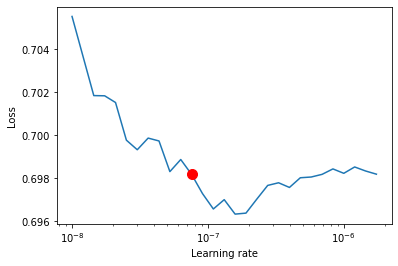

In [40]:
fig = lr_finder.plot(suggest=True)
fig.show()